In [1]:
import numpy as np


import os, glob
import astropy.io.fits as pyfits
from matplotlib import pyplot as plt
import scipy
import pandas as pd
import csv
import numpy.polynomial.polynomial as poly
from scipy.integrate import quad
# import detrend as de
from scipy.interpolate import interp1d
from scipy.integrate import simps
from scipy import interpolate

from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})


from astropy.io import ascii

import lightkurve as lk
from lightkurve import search_lightcurvefile

import time as ttt

# 1. Light curve preprocessing and flare candidates collection.
## 1.1 Download a TESS short cadence light curve
## 1.2 Flare candidates collection
## 1.3 Estimate the four features/characteristics of all flare candidates

# 2. Flare identification with Machine-Learning models
## 2.1 Load the models
## 2.2 Input the four features to the models for flare identification

## 1.1 Download a TESS short cadence light curve
## TIC 434103039 for the example

In [2]:
#the directory for the data storage. 
#change the directory address for your own convenience.
save_path = 'outputs'

In [3]:
#TIC	Number of Sectors	Number of Flares
#364588501	34	559
#201883033	4	110
#140045538	3	229
#441398770	3	169
#229147927	5	58
#63781635	2	17
#25118964	33	355
#231017428	4	97
#234506911	6	98
#220433363	22	845
#231914259	6	157
#365006789	3	75
#150359500	32	857
#388857263	4	117

In [4]:
TIC = 'TIC 140045538'
lcc = lk.search_lightcurve(TIC, author="SPOC", sector=1,cadence='short')

In [5]:
lcc.table["dataURL"]

<MaskedColumn name='dataURL' dtype='str73' length=1>
mast:TESS/product/tess2018206045859-s0001-0000000140045538-0120-s_lc.fits

In [6]:
search_result = lcc.download_all(download_dir=save_path)

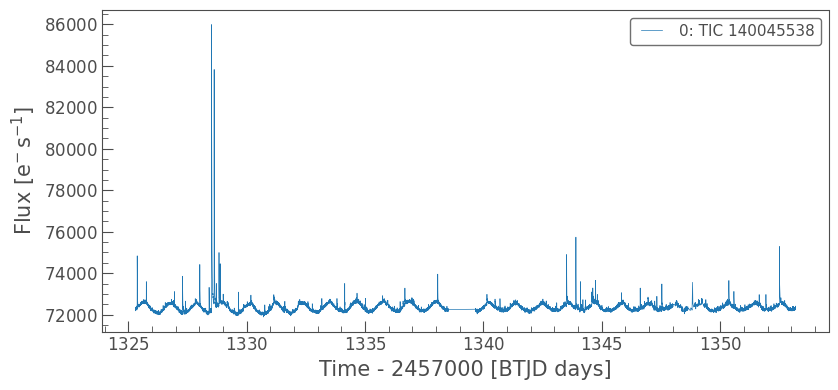

In [7]:
search_result.plot()
plt.show()

In [8]:
search_result[0].head()

<TessLightCurve length=5 LABEL="TIC 140045538" SECTOR=1 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>
       time             flux      ...   pos_corr1      pos_corr2   
                    electron / s  ...      pix            pix      
       Time           float32     ...    float32        float32    
------------------ -------------- ... -------------- --------------
1325.3004032409592  7.2234797e+04 ...  2.2464739e-02  5.9155762e-02
1325.3017921432606  7.2188492e+04 ... -2.2703882e-03  2.6285123e-02
 1325.303181045562  7.2207766e+04 ... -6.7850789e-03  2.2310857e-02
1325.3045699478632  7.2235648e+04 ... -7.8595541e-03  1.0938278e-02
 1325.305958849699  7.2302422e+04 ... -1.1981726e-02  1.1425514e-02

In [9]:
# time0.value

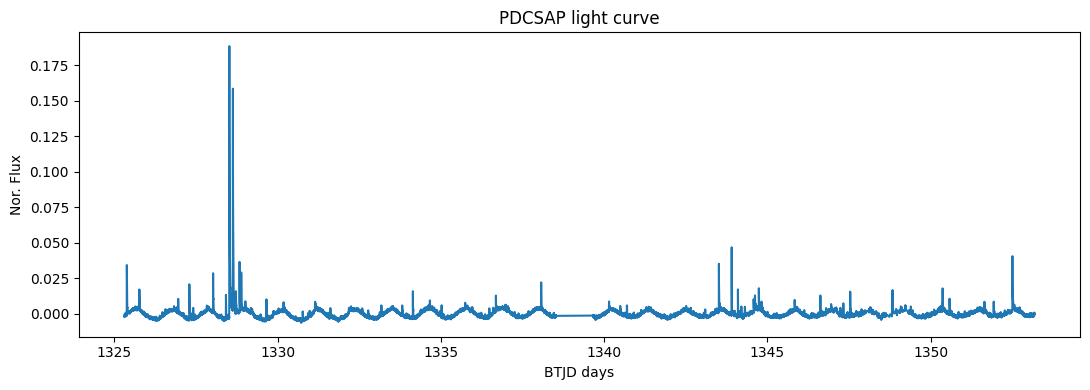

In [10]:
#pdcsap normalized light curve
plt.figure(figsize=(11,4))
plt.title('PDCSAP light curve')
time0 = search_result[0]['time'][search_result[0]['quality']==0].value
pdc0 = search_result[0]['pdcsap_flux'][search_result[0]['quality']==0].value 
pdc0 = np.array(pdc0) 

nor_pdc0 = pdc0 / np.nanmedian(pdc0)  - 1
plt.plot(time0, nor_pdc0)


plt.xlabel('BTJD days')
plt.ylabel('Nor. Flux')
plt.show()

In [11]:
#detrend the light curve by using the "flatten" funciton for 2 iteration
#the users can detrend the light curves with their own prefer methods

flatten_lc = search_result[0].flatten(window_length=201, polyorder=1, \
return_trend=False, break_tolerance=5, niters=2, \
sigma=3, mask = search_result[0]['quality'] != 0 ).to_pandas()
flatten_lc = flatten_lc.reset_index(drop=0)


fmean4 = np.nanmean(flatten_lc['flux'][flatten_lc['quality']==0])
fstd4 = np.nanstd(flatten_lc['flux'][flatten_lc['quality']==0])
fmedian4 = np.nanmedian(flatten_lc['flux'][flatten_lc['quality']==0])
fmad4 = np.nansum(abs(flatten_lc['flux'][flatten_lc['quality']==0]-fmedian4))/len(flatten_lc['flux'][flatten_lc['quality']==0])

mask1 = np.abs(flatten_lc['flux'] - 1) > 3 * fmad4
# mask1 = flatten_lc['flux'] > fmedian4 + 3 * fmad4

# mask1 = flatten_lc['flux'] > fmedian4 + 3 * fstd4
mask1 = mask1.values


#second flatten
mask2 = []
for i,v in enumerate(search_result[0]['quality'] != 0 ):
    if v == mask1[i]: 
        if v == False:
            mask2.append(False)

        if v == True:
            mask2.append(True)

    if v != mask1[i]:
        mask2.append(True)

mask2 = np.array(mask2)


flatten_lc2 = search_result[0].flatten(window_length=111, polyorder=2, \
                                      return_trend=False, break_tolerance=5, niters=5, \
                                      sigma=3, mask= mask2 ).to_pandas()
flatten_lc2 = flatten_lc2.reset_index(drop=0)

In [12]:
flatten_lc2.head()

time      flux  flux_err  timecorr  cadenceno  centroid_col  \
0  1325.300403  0.999090   0.00043  0.004668      70445    528.816611   
1  1325.301792  0.998449   0.00043  0.004668      70446    528.792890   
2  1325.303181  0.998716   0.00043  0.004669      70447    528.788629   
3  1325.304570  0.999101   0.00043  0.004669      70448    528.787195   
4  1325.305959  1.000025   0.00043  0.004669      70449    528.783770   

   centroid_row      sap_flux  sap_flux_err      sap_bkg  ...  psf_centr1  \
0   1068.567149  69163.593750     29.485779  2447.421387  ...         NaN   
1   1068.535585  69151.296875     29.482016  2457.644043  ...         NaN   
2   1068.531248  69181.195312     29.487997  2453.665771  ...         NaN   
3   1068.520758  69217.093750     29.501167  2470.340820  ...         NaN   
4   1068.521487  69257.984375     29.500063  2455.480957  ...         NaN   

   psf_centr1_err  psf_centr2  psf_centr2_err  mom_centr1  mom_centr1_err  \
0             NaN         NaN             NaN  528.816611        0.000336   
1             NaN         NaN             NaN  528.792890        0.000337   
2             NaN         NaN             NaN  528.788629        0.000337   
3             NaN         NaN             NaN  528.787195        0.000337   
4             NaN         NaN             NaN  528.783770        0.000337   

    mom_centr2  mom_centr2_err  pos_corr1  pos_corr2  
0  1068.567149        0.000356   0.022465   0.059156  
1  1068.535585        0.000356  -0.002270   0.026285  
2  1068.531248        0.000357  -0.006785   0.022311  
3  1068.520758        0.000357  -0.007860   0.010938  
4  1068.521487        0.000357  -0.011982   0.011426  

[5 rows x 24 columns]

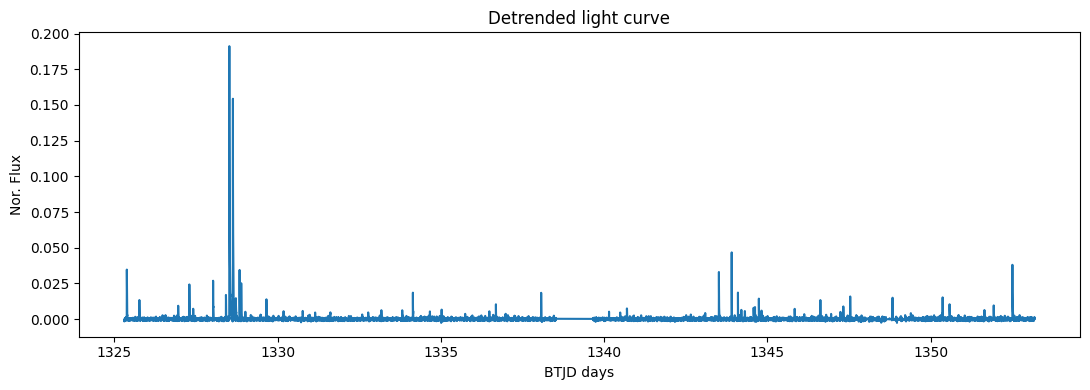

In [13]:
plt.figure(figsize=(11,4))

plt.title('Detrended light curve')

time1 = flatten_lc2['time'][flatten_lc2['quality']==0]
nor_pdc1 = flatten_lc2['flux'][flatten_lc2['quality']==0] -  1

plt.plot(time1, nor_pdc1)
plt.xlabel('BTJD days')
plt.ylabel('Nor. Flux')
plt.show()

In [14]:
len(time0), len(time1)

(18230, 18230)

In [15]:
# detrend_fits = nor_pdc0 - nor_pdc1 

# plt.figure(figsize=(11,4))
# plt.plot(time0, nor_pdc0)

# plt.plot(time0, detrend_fits)
# # plt.xlim(1375,)
# plt.xlabel('BTJD days')
# plt.ylabel('Nor. Flux')
# plt.show()

## 1.2 Flare candidates collection

Please read Section 2.1 in the paper for the criteria for flare canddiates selection.

In [16]:
fmean3 = np.nanmean(nor_pdc1)
fstd3 = np.nanstd(nor_pdc1)
fmedian3 = np.nanmedian(nor_pdc1) 
fmad3 = np.nansum(abs(nor_pdc1-fmedian3))\
/len(nor_pdc1)
mask3 = np.abs(nor_pdc1) > 3 * fstd3
mask3 = mask3.values

fmean4 = np.nanmean(np.ma.array(nor_pdc1.values, mask=mask3)) 
fmedian4 = np.nanmedian(np.ma.array(nor_pdc1.values, mask=mask3)) 
fstd4 = np.nanstd(np.ma.array(nor_pdc1.values, mask=mask3))

nor_pdc2 = nor_pdc1 - fmedian4

from itertools import groupby
from operator import itemgetter

time1 = time1.reset_index(drop=1)
nor_pdc2 = nor_pdc2.reset_index(drop=1)
# collect flare candidate
time1_sel3 = time1[nor_pdc2 >   1 * fstd4]

ind_f3 = time1_sel3.index

ind_f_cadi = []
for k, g in groupby(enumerate(ind_f3), lambda ix : ix[0] - ix[1]):
#     print( list(map(itemgetter(1), g)))
    ind_f_cadi.append(list(map(itemgetter(1), g)))

/Users/kyrabettwy/venvs/tf213/lib/python3.9/site-packages/numpy/core/fromnumeric.py:784: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


In [17]:
print('sigma of detrended light curve is ', fstd4)

sigma of detrended light curve is  0.0009397177743685514


In [18]:
ind_f = []
ind_f_cadi3 = []
# ind_f_cadi4 = []

flare_time_start = []
flare_time_end = []
flare_time_peak = []

flare_peak_amplitude = []



for i,v in enumerate(ind_f_cadi):
    ind_f_cand = ind_f_cadi[i]
    if len(ind_f_cand) >= 3:
        try:
            flare_time_start.append( time1[ind_f_cand[0]-1] ) 
            flare_time_end.append( time1[ind_f_cand[-1]+1])
            flare_time_peak.\
            append(time1.loc[ind_f_cand][nor_pdc2.loc[ind_f_cand] == np.max(nor_pdc2.loc[ind_f_cand])].values[0])
            
            flare_peak_amplitude.append(np.max(nor_pdc2.loc[ind_f_cand]))
            
            ind_f.append(i)
            ind_f_cadi3.append(ind_f_cand)


        except ValueError and KeyError:
            pass

In [19]:
print(len(ind_f), 'flare candidates')

130 flare candidates


In [20]:
# %matplotlib notebook

In [21]:
time1.loc[v[0]-1 : v[-1]+1].values

array([1353.17660999, 1353.17799885, 1353.1793877 ])

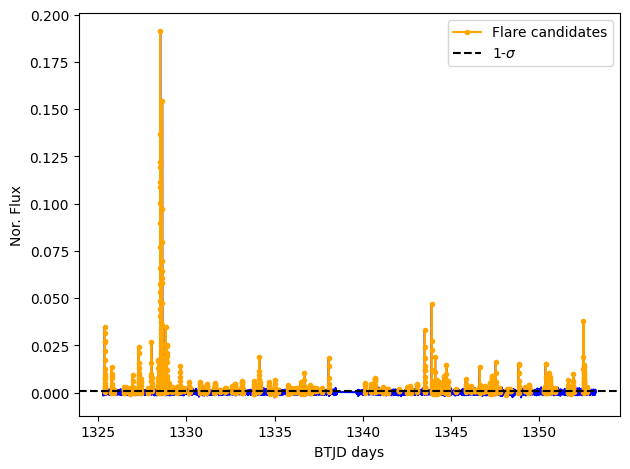

In [22]:
#normalized light curves
plt.plot(time1, nor_pdc2, color='b')

time1_candidates = []
nor_pdc2_candidates = []
#flare candidates
for i,v in enumerate(ind_f_cadi3):
    if i ==0:

        plt.plot(time1.loc[v[0]-1 : v[-1]+1], nor_pdc2.loc[v[0]-1 : v[-1]+1], \
                 '.-',color='orange', label='Flare candidates')
    else:
        plt.plot(time1.loc[v[0]-1 : v[-1]+1], nor_pdc2.loc[v[0]-1 : v[-1]+1], \
         '.-',color='orange')
    
    time1_candidates.append(time1.loc[v[0]-1 : v[-1]+1].values)
    nor_pdc2_candidates.append(nor_pdc2.loc[v[0]-1 : v[-1]+1].values)

plt.axhline(y = fstd4, linestyle='--', color='black', label=r'1-$\sigma$')

plt.legend(loc=1)
plt.xlabel('BTJD days')
plt.ylabel('Nor. Flux')
plt.show()

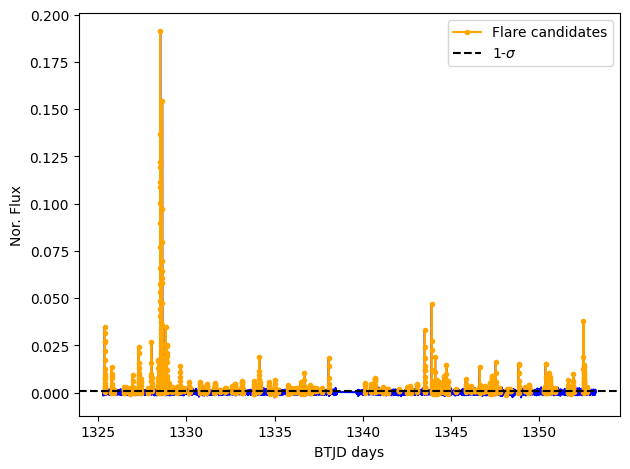

In [23]:
#normalized light curves
plt.plot(time1, nor_pdc2, color='b')

#flare candidates
for i,v in enumerate(ind_f_cadi3):
    if i ==0:

        plt.plot(time1.loc[v[0]-1 : v[-1]+1], nor_pdc2.loc[v[0]-1 : v[-1]+1], \
                 '.-',color='orange', label='Flare candidates')
    else:
        plt.plot(time1.loc[v[0]-1 : v[-1]+1], nor_pdc2.loc[v[0]-1 : v[-1]+1], \
         '.-',color='orange')


plt.axhline(y = fstd4, linestyle='--', color='black', label=r'1-$\sigma$')

plt.legend(loc=1)
plt.xlabel('BTJD days')
plt.ylabel('Nor. Flux')
plt.show()

## 1.3 Estimate the four features/characteristics of all flare candidates

### 1. The duration of the flare candidate ($\delta t$) in days.
### 2. The impulsive-decay time ratio ($\delta t_1 / \delta t_2$).
### 3. The upper-to-lower equivalent duration ratio ($ED_1 / ED_2$).
### 4. The peak amplitude signal-to-noise ratio ($A_f / \sigma$).

Please read the Section 2.1, Section 2.2, and Figure 1 in our paper for more specific details.


In [24]:
# 1. duration delta_t in days
flare_time_end = np.array(flare_time_end)
flare_time_start = np.array(flare_time_start)

delta_t = flare_time_end - flare_time_start

In [25]:
# delta_t

In [26]:
# 2. impulsive-decay time ratio (delta_t1/delta_t2)
flare_time_peak  = np.array(flare_time_peak)

delta_t1 = flare_time_peak - flare_time_start
delta_t2 = flare_time_end - flare_time_peak


delta_t1_to_delta_t2 = delta_t1 / delta_t2

In [27]:
# delta_t1_to_delta_t2

In [28]:
#3. The upper-to-lower equivalent duration ratio ( 𝐸𝐷1/𝐸𝐷2 )
# The equation of equivalent duration
def ED(x, y): #equivalent duration in second
    
    ef = 0
    for i2,v2 in enumerate(x):
        try:
#             print(x[i2], x[i2+1])

            '''1-D linear fitting'''
            coefs = poly.polyfit(x[i2:i2+2], y[i2:i2+2] ,1)

            '''1-D linear function for equivalent duration (ED) flare energy estimate method'''
            ew_flare_1 = lambda x :  coefs[1]*x+coefs[0]

            '''Integrate 1-D linear function for ED'''
            e1 = quad(ew_flare_1, x[i2], x[i2+1])
#             print(e1[0])
            ef+=e1[0]
        except IndexError:
            pass
        
    return ef * 86400

In [29]:
nor_pdc2_candidates[0]

array([0.00043423, 0.02701726, 0.03472451, 0.03139561, 0.02673958,
       0.0221887 , 0.01712276, 0.01251952, 0.00986667, 0.008329  ,
       0.00706455, 0.00488747, 0.00264224, 0.00331252, 0.00291433,
       0.00240343, 0.00123721, 0.00136517, 0.00098269, 0.00105546,
       0.00058833])

In [30]:
ED_all = []
ED1 = []
ED2 = []

for i,v in enumerate(nor_pdc2_candidates):
    time_fcad = time1_candidates[i]
    norf_fcd = nor_pdc2_candidates[i]
    amp_peak = flare_peak_amplitude[i]

    f = interpolate.interp1d(time_fcad, norf_fcd)
    t_array = np.linspace(np.nanmin(time_fcad), np.nanmax(time_fcad), 100)
    f_array = f(t_array)
    a = ED(t_array,  f_array)
    a2 = ED(t_array[ f_array < amp_peak/2],   f_array[ f_array < amp_peak/2 ])
    a1 = a - a2
    
    ED_all.append(a)
    ED1.append(a1)
    ED2.append(a2)

/Users/kyrabettwy/venvs/tf213/lib/python3.9/site-packages/numpy/polynomial/polynomial.py:1362: RankWarning: The fit may be poorly conditioned
  return pu._fit(polyvander, x, y, deg, rcond, full, w)


In [31]:
len(ED_all)

130

In [32]:
# ED1

In [33]:
# ED2

In [34]:
# The upper-to-lower equivalent duration ratio ( 𝐸𝐷1/𝐸𝐷2 )
ED1 = np.array(ED1)
ED2 = np.array(ED2)

ED1_to_ED2 = ED1 / ED2

/var/folders/3l/xp5scxws3kn9d72khd66rw7w0000gn/T/ipykernel_26150/1809543040.py:5: RuntimeWarning: divide by zero encountered in divide
  ED1_to_ED2 = ED1 / ED2


In [35]:
# ED1_to_ED2

In [36]:
#4. Peak amplitude to noise ratio 
flare_peak_amplitude = np.array(flare_peak_amplitude)
amp_to_std_ratio = flare_peak_amplitude / fstd4

In [37]:
# flare_peak_amplitude

In [38]:
# amp_to_std_ratio

In [39]:
# now you have all four features for all flare candidates

# 1. duration delta_t in days
delta_t
# 2. impulsive-decay time ratio (delta_t1/delta_t2)
delta_t1_to_delta_t2
#3. The upper-to-lower equivalent duration ratio ( 𝐸𝐷1/𝐸𝐷2 )
ED1_to_ED2
#4. Peak amplitude to noise ratio 
amp_to_std_ratio

array([ 36.95205904,  14.28044815,   1.40005228,   2.94046453,
         3.04319487,   2.63581453,   1.82447181,   1.8303464 ,
         2.75526142,   1.99078164,  10.01033858,   1.82053056,
        25.88313267,   2.6859055 ,   7.77865462,   2.69443262,
        28.65563003,  18.06954982,   2.01532595, 203.38957458,
       164.2192504 ,  15.64633594,   1.5893433 ,  36.67989282,
        26.765273  ,   5.54429886,   3.14695631,   3.33327537,
        14.80810663,   2.58080332,   5.94944121,   6.15262712,
         2.69078861,   3.31573951,   4.97788235,   1.61582239,
         2.53109817,   5.1005707 ,   1.47006113,   2.45386866,
         2.35826041,   3.51251232,   5.0380623 ,   2.74699907,
         6.70027943,   6.6521977 ,   2.76417026,   2.45976232,
        19.76608575,   5.79087692,   2.18541528,   2.45373326,
         7.13627023,   2.10333018,   1.60493175,   3.99761521,
         2.14833336,   2.79501518,   2.10956724,   2.82717701,
         2.46134411,   5.86644096,   3.25882506,  11.09


# 2. Flare identification with Machine-Learning models
## 2.1 Load the models
## 2.2 Input the four features to the models for flare identification

## 2.1 Load the models


In [40]:
#custom f1_score for our Deep Neural Network model
import tensorflow as tf

def f1_score(y_true, y_pred):
    y_pred = tf.round(y_pred)
    tp = tf.reduce_sum(tf.cast(y_true * y_pred, 'float'), axis=0)
    fp = tf.reduce_sum(tf.cast((1 - y_true) * y_pred, 'float'), axis=0)
    fn = tf.reduce_sum(tf.cast(y_true * (1 - y_pred), 'float'), axis=0)

    p = tp / (tp + fp + tf.keras.backend.epsilon())
    r = tp / (tp + fn + tf.keras.backend.epsilon())

    f1 = 2*p*r / (p + r + tf.keras.backend.epsilon())
    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)
    return tf.reduce_mean(f1)

In [41]:
#models are stored in the directory "ML_models"

In [42]:
# cd ML_models/

In [43]:
#RandomForest

import joblib

loaded_model = joblib.load('RandomForestClassifier_flare_classification-by-Lin.pkl') #ver 13 is better than 14

# Now 'loaded_model' is the trained Random Forest model

# Deep Neural Network
from tensorflow.keras.models import load_model

model_dnn = load_model(os.path.join("DNNClassifier_flare_classification-by-Lin.keras"), \
                       custom_objects={'f1_score': f1_score}, compile=False)

#XGBoost

from xgboost import XGBClassifier
loaded_model_xgboost =  XGBClassifier()

loaded_model_xgboost.load_model('XGBoostClassifier_flare_classification-by-Lin.json')

2025-10-13 22:58:16.160424: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M4 Max
2025-10-13 22:58:16.160448: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 36.00 GB
2025-10-13 22:58:16.160452: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 13.50 GB
2025-10-13 22:58:16.160475: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-10-13 22:58:16.160486: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


### Crossmatching with Gunther et al 2020 flare values

In [44]:
gunther_values = pd.read_csv("Gunther_2020.csv")
gunther_values

TIC  Outbst  Flare         tpeak   e_tpeak   E_tpeak      Amp  \
0       2760232       1      1  2.458357e+06  0.000863  0.000854  0.01475   
1       2760232       2      1  2.458358e+06  0.001059  0.001026  0.01389   
2       2760232       3      1  2.458360e+06  0.000026  0.000026  0.28258   
3       2760232       3      2  2.458360e+06  0.000195  0.000195  0.04634   
4       2760232       3      3  2.458360e+06  0.001735  0.001565  0.01665   
...         ...     ...    ...           ...       ...       ...      ...   
8690  471015484       9      1  2.458371e+06  0.000070  0.000073  0.13585   
8691  471015484      10      1  2.458373e+06  0.000201  0.000249  0.04478   
8692  471015484      10      2  2.458373e+06  0.000323  0.000329  0.02797   
8693  471015484      11      1  2.458379e+06  0.000151  0.000161  0.03871   
8694  471015484      12      1  2.458380e+06  0.000078  0.000075  0.10938   

        e_Amp    E_Amp   FWHMdt  e_FWHMdt  E_FWHMdt  Ebol  e_Ebol  E_Ebol  \
0     0.00168  0.00170  0.01958   0.00307   0.00375   NaN     NaN     NaN   
1     0.00162  0.00175  0.01612   0.00338   0.00394   NaN     NaN     NaN   
2     0.00817  0.00949  0.00196   0.00017   0.00017   NaN     NaN     NaN   
3     0.00589  0.00598  0.00610   0.00063   0.00062   NaN     NaN     NaN   
4     0.00185  0.00155  0.05816   0.00920   0.00928   NaN     NaN     NaN   
...       ...      ...      ...       ...       ...   ...     ...     ...   
8690  0.00572  0.00568  0.00254   0.00018   0.00020   NaN     NaN     NaN   
8691  0.00437  0.00442  0.00410   0.00100   0.00100   NaN     NaN     NaN   
8692  0.00334  0.00339  0.00744   0.00207   0.00283   NaN     NaN     NaN   
8693  0.00519  0.00646  0.00266   0.00070   0.00079   NaN     NaN     NaN   
8694  0.00683  0.00801  0.00238   0.00031   0.00031   NaN     NaN     NaN   

      MCME  e_MCME  E_MCME  
0      NaN     NaN     NaN  
1      NaN     NaN     NaN  
2      NaN     NaN     NaN  
3      NaN     NaN     NaN  
4      NaN     NaN     NaN  
...    ...     ...     ...  
8690   NaN     NaN     NaN  
8691   NaN     NaN     NaN  
8692   NaN     NaN     NaN  
8693   NaN     NaN     NaN  
8694   NaN     NaN     NaN  

[8695 rows x 18 columns]

In [45]:
## https://tapvizier.cds.unistra.fr/adql/?%20J/AJ/159/60/table1

tics = [140045538, 434103039, 364588501]
gunther_values_subset = gunther_values[gunther_values["TIC"].isin(tics)]

gunther_values_subset = gunther_values_subset.copy()
gunther_values_subset["t_peak"] = gunther_values_subset["tpeak"] - 2457000
gunther_values_subset

TIC  Outbst  Flare         tpeak   e_tpeak   E_tpeak      Amp  \
1794  140045538       1      1  2.458325e+06  0.000023  0.000027  0.04692   
1795  140045538       1      2  2.458325e+06  0.000071  0.000072  0.02298   
1796  140045538       2      1  2.458326e+06  0.000079  0.000083  0.01706   
1797  140045538       4      1  2.458327e+06  0.000089  0.000077  0.01400   
1798  140045538       4      2  2.458327e+06  0.000467  0.000578  0.00413   
...         ...     ...    ...           ...       ...       ...      ...   
7574  364588501      19      1  2.458378e+06  0.000310  0.000384  0.01045   
7575  364588501      20      1  2.458380e+06  0.000330  0.000428  0.00491   
8426  434103039       1      1  2.458354e+06  0.000511  0.000600  0.00283   
8427  434103039       2      1  2.458355e+06  0.000043  0.000043  0.01937   
8428  434103039       3      1  2.458356e+06  0.000105  0.000106  0.00694   

        e_Amp    E_Amp   FWHMdt  e_FWHMdt  E_FWHMdt          Ebol  \
1794  0.00250  0.00315  0.00148   0.00019   0.00020  6.849000e+32   
1795  0.00097  0.00099  0.00604   0.00036   0.00035  1.215000e+33   
1796  0.00061  0.00064  0.00368   0.00029   0.00030  5.831000e+32   
1797  0.00151  0.00271  0.00136   0.00036   0.00037  1.721000e+32   
1798  0.00100  0.00122  0.00637   0.00357   0.00552  2.545000e+32   
...       ...      ...      ...       ...       ...           ...   
7574  0.00072  0.00073  0.00945   0.00139   0.00171  2.839000e+34   
7575  0.00102  0.00144  0.00380   0.00125   0.00156  5.584000e+33   
8426  0.00038  0.00040  0.00754   0.00188   0.00228           NaN   
8427  0.00062  0.00065  0.00332   0.00022   0.00023           NaN   
8428  0.00056  0.00061  0.00323   0.00049   0.00055           NaN   

            e_Ebol        E_Ebol          MCME        e_MCME        E_MCME  \
1794  6.542000e+31  6.193000e+31  7.271000e+19  6.949000e+19  8.534000e+20   
1795  9.217000e+31  1.067000e+32  9.315000e+19  9.045000e+19  1.994000e+21   
1796  3.484000e+31  3.885000e+31  7.669000e+19  7.282000e+19  1.570000e+21   
1797  2.284000e+31  2.920000e+31  5.610000e+19  5.330000e+19  8.042000e+20   
1798  1.450000e+32  1.598000e+32  2.644000e+19  2.461000e+19  5.018000e+20   
...            ...           ...           ...           ...           ...   
7574  3.510000e+33  5.180000e+33  8.469000e+20  8.023000e+20  1.638000e+22   
7575  1.122000e+33  1.690000e+33  4.259000e+20  3.883000e+20  8.495000e+21   
8426           NaN           NaN           NaN           NaN           NaN   
8427           NaN           NaN           NaN           NaN           NaN   
8428           NaN           NaN           NaN           NaN           NaN   

           t_peak  
1794  1325.377294  
1795  1325.380283  
1796  1325.762618  
1797  1326.951894  
1798  1326.910894  
...           ...  
7574  1378.195760  
7575  1379.590749  
8426  1354.285810  
8427  1355.208799  
8428  1356.157354  

[143 rows x 19 columns]

In [46]:
## matching true/false with ground truth flares

In [47]:
import os
import pandas as pd

folder_path = "flare_outputs" 

all_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.csv')]

df_list = []
for file in all_files:
    temp_df = pd.read_csv(file)
    temp_df['source_file'] = os.path.basename(file)
    df_list.append(temp_df)

combined_candidates = pd.concat(df_list, ignore_index=True)
combined_candidates.head()

t_peak   delta_t     t1/t2   ED1/ED2    Af/STD  class  \
0  2088.339786  0.013889  1.000000  0.164172  4.286815    NaN   
1  2088.938410  0.005556  0.333333  0.431647  2.740663    NaN   
2  2089.105080  0.019445  0.400000  0.343057  9.652728    NaN   
3  2089.437030  0.016667  0.333333  0.414649  3.205780    NaN   
4  2089.531476  0.013889  0.250000  0.346742  7.990032    NaN   

            source_file  
0  434103039_TESS29.csv  
1  434103039_TESS29.csv  
2  434103039_TESS29.csv  
3  434103039_TESS29.csv  
4  434103039_TESS29.csv

In [48]:
len(combined_candidates)

1318

In [49]:
import pandas as pd

df1 = combined_candidates.drop_duplicates(subset="t_peak").sort_values("t_peak")
df2 = gunther_values_subset.drop_duplicates(subset="t_peak").sort_values("t_peak")

merged_gunther = pd.merge_asof(df1, df2, on="t_peak", direction="nearest", tolerance=0.001)

merged_gunther["match"] = merged_gunther["Outbst"].notna()

In [50]:
merged_gunther

t_peak   delta_t     t1/t2    ED1/ED2     Af/STD  class  \
0     1325.378182  0.027778  0.111111   0.342033  36.952059    NaN   
1     1325.436878  0.030555  1.000000   0.268341   8.611522    NaN   
2     1325.762907  0.012500  0.285714   0.321555  14.280448    NaN   
3     1325.832708  0.005556  3.000000   0.474358   2.431604    NaN   
4     1325.841041  0.005556  1.000000  59.993183   1.580047    NaN   
...           ...       ...       ...        ...        ...    ...   
1313  3906.083459  0.008333  0.200000   0.308641   7.128121    NaN   
1314  3906.350119  0.006944  0.250000   0.243730   2.728723    NaN   
1315  3906.493171  0.011111  0.600000   0.356510   5.362444    NaN   
1316  3906.559836  0.012500  0.800000   0.399167   2.415497    NaN   
1317  3906.757053  0.008333  0.500000   0.272057  12.297324    NaN   

               source_file          TIC  Outbst  Flare  ...   FWHMdt  \
0     364588501_TESS11.csv  140045538.0     1.0    1.0  ...  0.00148   
1      364588501_TESS1.csv          NaN     NaN    NaN  ...      NaN   
2     364588501_TESS11.csv  140045538.0     2.0    1.0  ...  0.00368   
3      364588501_TESS1.csv          NaN     NaN    NaN  ...      NaN   
4      364588501_TESS1.csv          NaN     NaN    NaN  ...      NaN   
...                    ...          ...     ...    ...  ...      ...   
1313  140045538_TESS95.csv          NaN     NaN    NaN  ...      NaN   
1314  140045538_TESS95.csv          NaN     NaN    NaN  ...      NaN   
1315  140045538_TESS95.csv          NaN     NaN    NaN  ...      NaN   
1316  140045538_TESS95.csv          NaN     NaN    NaN  ...      NaN   
1317  140045538_TESS95.csv          NaN     NaN    NaN  ...      NaN   

      e_FWHMdt  E_FWHMdt          Ebol        e_Ebol        E_Ebol  \
0      0.00019    0.0002  6.849000e+32  6.542000e+31  6.193000e+31   
1          NaN       NaN           NaN           NaN           NaN   
2      0.00029    0.0003  5.831000e+32  3.484000e+31  3.885000e+31   
3          NaN       NaN           NaN           NaN           NaN   
4          NaN       NaN           NaN           NaN           NaN   
...        ...       ...           ...           ...           ...   
1313       NaN       NaN           NaN           NaN           NaN   
1314       NaN       NaN           NaN           NaN           NaN   
1315       NaN       NaN           NaN           NaN           NaN   
1316       NaN       NaN           NaN           NaN           NaN   
1317       NaN       NaN           NaN           NaN           NaN   

              MCME        e_MCME        E_MCME  match  
0     7.271000e+19  6.949000e+19  8.534000e+20   True  
1              NaN           NaN           NaN  False  
2     7.669000e+19  7.282000e+19  1.570000e+21   True  
3              NaN           NaN           NaN  False  
4              NaN           NaN           NaN  False  
...            ...           ...           ...    ...  
1313           NaN           NaN           NaN  False  
1314           NaN           NaN           NaN  False  
1315           NaN           NaN           NaN  False  
1316           NaN           NaN           NaN  False  
1317           NaN           NaN           NaN  False  

[1318 rows x 26 columns]

In [51]:
len(merged_gunther[merged_gunther["match"] == 1])

86

In [52]:
model_dnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 4)                 0         
                                                                 
 dense_4 (Dense)             (None, 480)               2400      
                                                                 
 dense_5 (Dense)             (None, 192)               92352     
                                                                 
 dense_6 (Dense)             (None, 512)               98816     
                                                                 
 dense_7 (Dense)             (None, 2)                 1026      
                                                                 
Total params: 194594 (760.13 KB)
Trainable params: 194594 (760.13 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [53]:
# Deep Neural Network

from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam 

model_dnn = load_model(os.path.join("DNNClassifier_flare_classification-by-Lin.keras"), \
                       custom_objects={'f1_score': f1_score}, compile=False)

model_dnn.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=[f1_score])

X_train = merged_gunther[['delta_t', 't1/t2', 'ED1/ED2', 'Af/STD']]
y_train = merged_gunther["match"]

keep_rows = ~np.isinf(X_train).any(axis=1)
X_train_clean = X_train[keep_rows]
y_train_clean = y_train[keep_rows]

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_clean)

from tensorflow.keras.utils import to_categorical
y_train_cat = to_categorical(y_train_clean)

history = model_dnn.fit(X_train_scaled, y_train_cat, epochs=250, batch_size=32, validation_split=0.15, shuffle=True)

Epoch 1/250


2025-10-13 22:58:29.246872: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


35/35 [==============================] - ETA: 0s - loss: 584.0242 - f1_score: 0.5000

2025-10-13 22:58:30.979040: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


35/35 [==============================] - 2s 18ms/step - loss: 584.0242 - f1_score: 0.5000 - val_loss: 777.3199 - val_f1_score: 0.4907
Epoch 2/250
35/35 [==============================] - 0s 4ms/step - loss: 330.9289 - f1_score: 0.5088 - val_loss: 400.0655 - val_f1_score: 0.4907
Epoch 3/250
35/35 [==============================] - 0s 4ms/step - loss: 160.5901 - f1_score: 0.5839 - val_loss: 291.1337 - val_f1_score: 0.4787
Epoch 4/250
35/35 [==============================] - 0s 4ms/step - loss: 106.1149 - f1_score: 0.5860 - val_loss: 108.7803 - val_f1_score: 0.4004
Epoch 5/250
35/35 [==============================] - 0s 4ms/step - loss: 90.7792 - f1_score: 0.5168 - val_loss: 150.9820 - val_f1_score: 0.4707
Epoch 6/250
35/35 [==============================] - 0s 4ms/step - loss: 58.6736 - f1_score: 0.5300 - val_loss: 48.6026 - val_f1_score: 0.4954
Epoch 7/250
35/35 [==============================] - 0s 4ms/step - loss: 46.2793 - f1_score: 0.5468 - val_loss: 14.6614 - val_f1_score: 0.4954
E

## Figure 5

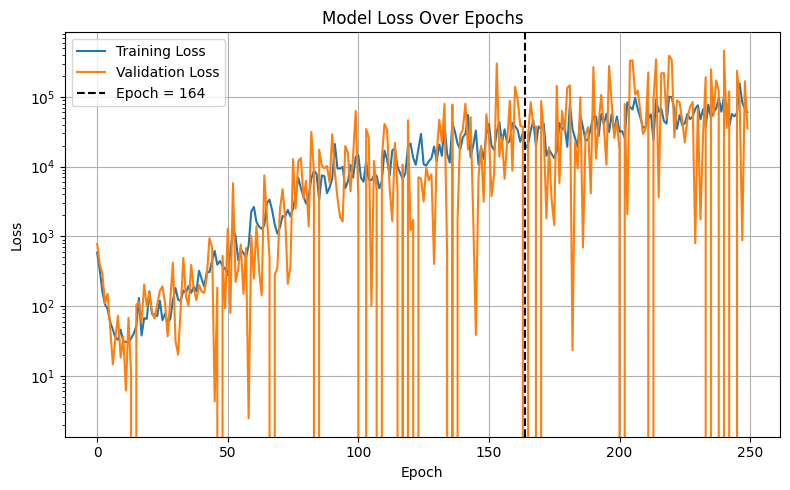

In [54]:
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale('log')

plt.axvline(164, ls = "--", color = "black", label = "Epoch = 164")
plt.legend()

plt.grid(True)
plt.show()

In [55]:
#XGBoost
from xgboost import XGBClassifier
loaded_model_xgboost =  XGBClassifier()

loaded_model_xgboost.load_model('XGBoostClassifier_flare_classification-by-Lin.json')

## 2.2 Input the four features to the models for flare identification

Gather the four features into a table

In [56]:
#RandomForest

import joblib

loaded_model = joblib.load('RandomForestClassifier_flare_classification-by-Lin.pkl') #ver 13 is better than 14

# Now 'loaded_model' is the trained Random Forest model

# Deep Neural Network
from tensorflow.keras.models import load_model

model_dnn = load_model(os.path.join("DNNClassifier_flare_classification-by-Lin.keras"), \
                       custom_objects={'f1_score': f1_score}, compile=False)

#XGBoost

from xgboost import XGBClassifier
loaded_model_xgboost =  XGBClassifier()

loaded_model_xgboost.load_model('XGBoostClassifier_flare_classification-by-Lin.json')

In [57]:
## Using specific folder:

input_candidates_title = "140045538_TESS28.csv"
input_candidates = pd.read_csv("flare_outputs/" + input_candidates_title)
input_candidates.head()

t_peak   delta_t  t1/t2   ED1/ED2    Af/STD  class
0  2062.141791  0.009722   0.75  0.596949  5.748762    NaN
1  2062.169569  0.005556   1.00  0.516040  3.272298    NaN
2  2062.243180  0.006944   0.25  0.359756  3.217975    NaN
3  2062.390403  0.005556   1.00  0.264939  3.191647    NaN
4  2062.397347  0.005556   3.00  0.218101  2.420923    NaN

In [58]:
#input_candidates = \
#pd.DataFrame([], columns=['delta_t', 't1/t2', 'ED1/ED2', 'Af/STD', 'class'])

#input_candidates['delta_t'] = delta_t
#input_candidates['t1/t2'] = delta_t1_to_delta_t2
#input_candidates['ED1/ED2'] = ED1_to_ED2
#input_candidates['Af/STD'] = amp_to_std_ratio

#input_candidates.head()

In [59]:
#Input format
X = input_candidates.values[ :, [1,2,3,4] ]

In [60]:
X = np.nan_to_num(X, nan=0.0, posinf=1e6, neginf=-1e6)
X = np.clip(X, -1e6, 1e6)

In [61]:
#Models' predicitons

#Random Forest
y_pred_rf = loaded_model.predict(X)
y_predv2_rf = np.argmax(y_pred_rf,axis=1) 


#DNN 
X1 = np.asarray(X).astype(np.float64)
y_pred_dnn = model_dnn.predict(X1)
y_pred_dnn_v2 = np.argmax(y_pred_dnn,axis=1) 
threshold = 0.5

y_pred_dnn_v2 = []
for i,v in enumerate(y_pred_dnn):
    try:
        y_pred_dnn_v2.append(np.where(y_pred_dnn[i]> threshold) [0][0])
    except IndexError:
        y_pred_dnn_v2.append(0)
y_pred_dnn_v2 = np.array(y_pred_dnn_v2)


#XGBoost
y_pred_xgbr = loaded_model_xgboost.predict(X)
y_pred_xgbr_v2 = np.argmax(y_pred_xgbr,axis=1) #classifier

4/4 [==============================] - 0s 2ms/step


2025-10-13 22:59:15.177238: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


In [62]:
y_predv2_rf

array([1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0,
       0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0,
       0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1,
       1, 1, 1, 0, 0, 1, 0, 1, 1, 1])

Flare identification with the models

In [63]:
y_pred_dnn_v2

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [64]:
y_pred_xgbr_v2

array([1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 0, 0, 1, 0, 1, 1, 0])

In [65]:
#Three models' prediction voting

#combine the prediction from the three models
combined_pred = np.column_stack((y_predv2_rf, y_pred_dnn_v2, y_pred_xgbr_v2))


In [66]:
# combined_pred

In [67]:
from statistics import mode

votes = np.array(list(map(mode, combined_pred)))

In [68]:
print("Number of RF's flares:", len(votes[y_predv2_rf==1]))
print("Number of DNN's flares:", len(votes[y_pred_dnn_v2==1]))
print("Number of XGB's flares:", len(votes[y_pred_xgbr_v2==1]))
print("Number of Voted flares:", len(votes[votes==1]))

Number of RF's flares: 66
Number of DNN's flares: 110
Number of XGB's flares: 52
Number of Voted flares: 68


In [69]:
#input_candidates['F_amp'] = flare_peak_amplitude
#input_candidates['time_start(BTJD)'] = flare_time_start
#input_candidates['time_peak(BTJD)'] = flare_time_peak
#input_candidates['time_end(BTJD)'] = flare_time_end
input_candidates['class'] = votes

In [70]:
input_candidates['xgbr'] = (y_pred_xgbr_v2 == 1).astype(int)
input_candidates['dnn']  = (y_pred_dnn_v2 == 1).astype(int)
input_candidates['rf']   = (y_predv2_rf == 1).astype(int)

In [71]:
input_candidates

t_peak   delta_t     t1/t2   ED1/ED2     Af/STD  class  xgbr  dnn  \
0    2062.141791  0.009722  0.750000  0.596949   5.748762      1     1    1   
1    2062.169569  0.005556  1.000000  0.516040   3.272298      1     0    1   
2    2062.243180  0.006944  0.250000  0.359756   3.217975      0     0    1   
3    2062.390403  0.005556  1.000000  0.264939   3.191647      1     0    1   
4    2062.397347  0.005556  3.000000  0.218101   2.420923      1     0    1   
..           ...       ...       ...       ...        ...    ...   ...  ...   
115  2084.756799  0.012500  1.250000  0.597722   4.732054      1     1    1   
116  2084.763743  0.008333  0.200000  0.397885   2.775823      0     0    1   
117  2084.865130  0.012500  0.285714  0.299390  11.245058      1     1    1   
118  2085.047069  0.011111  0.600000  0.342784   6.186736      1     1    1   
119  2085.083179  0.005555  0.333333  0.232080   2.751325      1     0    1   

     rf  
0     1  
1     1  
2     0  
3     1  
4     1  
..   ..  
115   1  
116   0  
117   1  
118   1  
119   1  

[120 rows x 9 columns]

In [112]:
# run if saving individual outputs

input_candidates.to_csv("output_cands/" + f"input_rfnnxg_{input_candidates_title}.csv", index=False)

## Plots

In [72]:
## installing the gunther flares for comparison for sector 1 

merged_gunther_1400 = pd.read_csv("merged_gunther_1400.csv")
merged_gunther_1400 = gunther_values[gunther_values["TIC"] == 140045538]
merged_gunther_1400 = merged_gunther_1400.copy()
merged_gunther_1400["t_peak"] = merged_gunther_1400["tpeak"] - 2457000
merged_gunther_1400

TIC  Outbst  Flare         tpeak   e_tpeak   E_tpeak      Amp  \
1794  140045538       1      1  2.458325e+06  0.000023  0.000027  0.04692   
1795  140045538       1      2  2.458325e+06  0.000071  0.000072  0.02298   
1796  140045538       2      1  2.458326e+06  0.000079  0.000083  0.01706   
1797  140045538       4      1  2.458327e+06  0.000089  0.000077  0.01400   
1798  140045538       4      2  2.458327e+06  0.000467  0.000578  0.00413   
...         ...     ...    ...           ...       ...       ...      ...   
1881  140045538      55      1  2.458351e+06  0.000113  0.000143  0.01189   
1882  140045538      56      1  2.458352e+06  0.000196  0.000198  0.00706   
1883  140045538      57      1  2.458352e+06  0.000107  0.000113  0.00994   
1884  140045538      58      1  2.458353e+06  0.000029  0.000030  0.05174   
1885  140045538      58      2  2.458353e+06  0.000623  0.000722  0.00868   

        e_Amp    E_Amp   FWHMdt  e_FWHMdt  E_FWHMdt          Ebol  \
1794  0.00250  0.00315  0.00148   0.00019   0.00020  6.849000e+32   
1795  0.00097  0.00099  0.00604   0.00036   0.00035  1.215000e+33   
1796  0.00061  0.00064  0.00368   0.00029   0.00030  5.831000e+32   
1797  0.00151  0.00271  0.00136   0.00036   0.00037  1.721000e+32   
1798  0.00100  0.00122  0.00637   0.00357   0.00552  2.545000e+32   
...       ...      ...      ...       ...       ...           ...   
1881  0.00073  0.00073  0.00425   0.00054   0.00061  5.259000e+32   
1882  0.00068  0.00072  0.00356   0.00069   0.00079  2.831000e+32   
1883  0.00050  0.00053  0.00534   0.00054   0.00053  5.174000e+32   
1884  0.00182  0.00203  0.00145   0.00012   0.00011  6.581000e+32   
1885  0.00200  0.00254  0.01904   0.00481   0.01111  1.618000e+33   

            e_Ebol        E_Ebol          MCME        e_MCME        E_MCME  \
1794  6.542000e+31  6.193000e+31  7.271000e+19  6.949000e+19  8.534000e+20   
1795  9.217000e+31  1.067000e+32  9.315000e+19  9.045000e+19  1.994000e+21   
1796  3.484000e+31  3.885000e+31  7.669000e+19  7.282000e+19  1.570000e+21   
1797  2.284000e+31  2.920000e+31  5.610000e+19  5.330000e+19  8.042000e+20   
1798  1.450000e+32  1.598000e+32  2.644000e+19  2.461000e+19  5.018000e+20   
...            ...           ...           ...           ...           ...   
1881  8.211000e+31  5.929000e+31  7.611000e+19  6.908000e+19  1.840000e+21   
1882  5.138000e+31  6.428000e+31  4.350000e+19  4.092000e+19  9.090000e+20   
1883  4.699000e+31  2.957000e+31  5.810000e+19  5.519000e+19  6.898000e+20   
1884  2.508000e+31  4.061000e+31  8.033000e+19  7.583000e+19  1.348000e+21   
1885  5.800000e+32  1.339000e+33  1.502000e+20  1.478000e+20  1.395000e+21   

           t_peak  
1794  1325.377294  
1795  1325.380283  
1796  1325.762618  
1797  1326.951894  
1798  1326.910894  
...           ...  
1881  1350.578834  
1882  1351.647574  
1883  1351.931778  
1884  1352.503874  
1885  1352.510028  

[92 rows x 19 columns]

## Figure 4

In [73]:
import pandas as pd
import glob
import os

csv_files = glob.glob('output_cands/input_*.csv')

df_list = []

for file in csv_files:
    df = pd.read_csv(file)
    df_list.append(df)

flares_concat = pd.concat(df_list, ignore_index=True)
flares_concat

t_peak   delta_t     t1/t2    ED1/ED2    Af/STD  class  xgbr  dnn  \
0     1325.436878  0.030555  1.000000   0.268341  8.611522      1     1    1   
1     1325.832708  0.005556  3.000000   0.474358  2.431604      0     0    0   
2     1325.841041  0.005556  1.000000  59.993183  1.580047      0     0    1   
3     1325.895207  0.005556  1.000000   0.595924  1.521126      0     0    0   
4     1326.104928  0.005556  3.000000   0.486841  1.798424      0     0    0   
...           ...       ...       ...        ...       ...    ...   ...  ...   
1243  1435.765853  0.005555  0.333333   0.312779  3.508194      0     0    0   
1244  1435.860296  0.012500  1.250000   0.168099  3.873887      0     0    0   
1245  1435.867240  0.005555  0.333333   0.624256  1.625581      0     0    0   
1246  1436.039460  0.008333  0.200000   0.281704  3.062482      0     0    0   
1247  1436.049182  0.005555  1.000000   0.416848  1.989551      0     0    0   

      rf  
0      1  
1      1  
2      0  
3      0  
4      0  
...   ..  
1243   0  
1244   0  
1245   0  
1246   0  
1247   0  

[1248 rows x 9 columns]

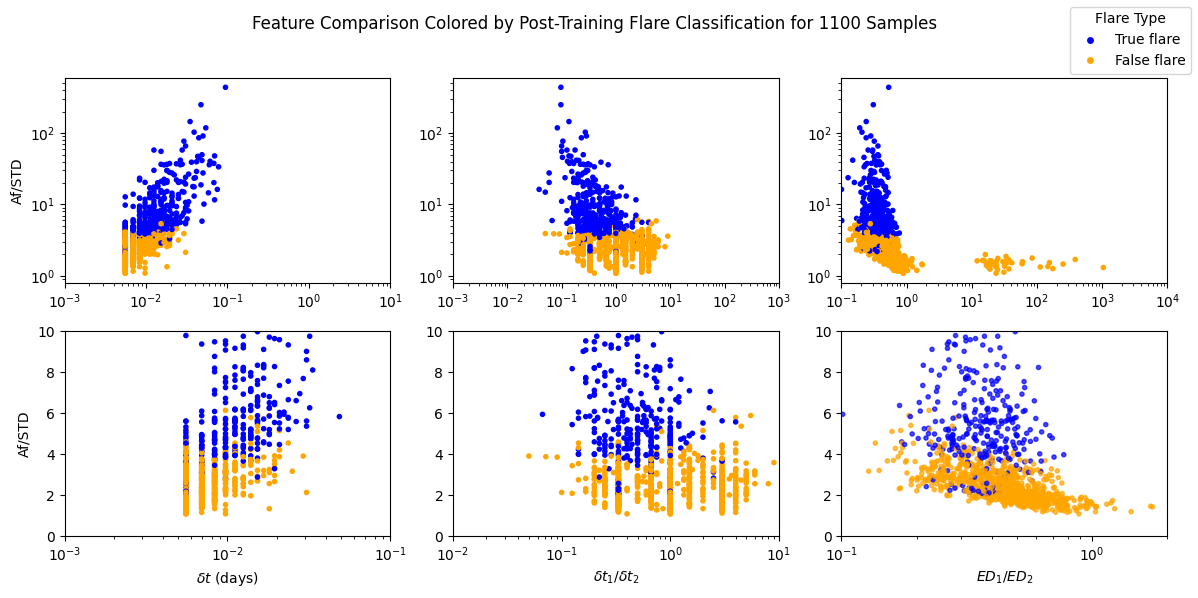

In [74]:
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(2, 3, figsize=(12, 6))

colors = flares_concat["class"].map({0: 'orange', 1: 'blue'})

axes[0,0].scatter(flares_concat["delta_t"], flares_concat["Af/STD"], c=colors, s=9)
axes[0,1].scatter(flares_concat["t1/t2"], flares_concat["Af/STD"], c=colors, s=9)
axes[0,2].scatter(flares_concat["ED1/ED2"], flares_concat["Af/STD"], c=colors, s=9)

for ax in axes[0, :]:
    ax.set_xscale('log')
    ax.set_yscale('log')

axes[1,0].scatter(flares_concat["delta_t"], flares_concat["Af/STD"], c=colors, s=9)
axes[1,1].scatter(flares_concat["t1/t2"], flares_concat["Af/STD"], c=colors, s=9)
axes[1,2].scatter(flares_concat["ED1/ED2"], flares_concat["Af/STD"], c=colors, s=9, alpha = 0.7)

for ax in axes[1, :]:
    ax.set_ylim(1e-10, 10) 
    ax.set_yscale('linear')
    ax.set_xscale('log')

axes[0,0].set_xlim(1e-3, 10)
axes[0,1].set_xlim(1e-3, 1e3)
axes[0,2].set_xlim(1e-1, 1e4)

axes[1,0].set_xlim(1e-3, 1e-1)
axes[1,1].set_xlim(1e-2, 1e1)
axes[1,2].set_xlim(1e-1, 2)

axes[1,0].set_xlabel(r'$\delta t$ (days)')
axes[1,1].set_xlabel(r'$\delta t_1 / \delta t_2$')
axes[1,2].set_xlabel(r'$ED_1 / ED_2$')

axes[0,0].set_ylabel('Af/STD')
axes[1,0].set_ylabel('Af/STD')

from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], marker='o', color='w', label='True flare',
           markerfacecolor='blue', markersize=6),
                   Line2D([0], [0], marker='o', color='w', label='False flare',
                          markerfacecolor='orange', markersize=6)]

fig.legend(handles=legend_elements, loc='upper right', frameon=True, title="Flare Type")

plt.tight_layout(rect=[0, 0, 1, 0.9])
fig.suptitle("Feature Comparison Colored by Post-Training Flare Classification for 1100 Samples")
plt.show()

## Figure 8

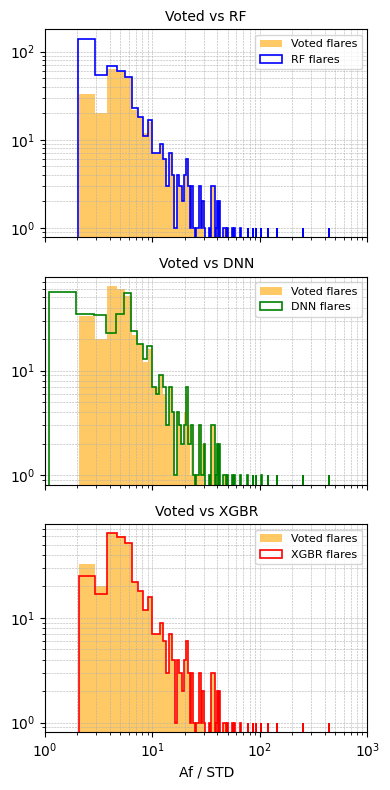

In [75]:
import matplotlib.pyplot as plt
import numpy as np

voted_flares = flares_concat[flares_concat["class"] == 1]["Af/STD"]
rf_flares    = flares_concat[flares_concat["rf"] == 1]["Af/STD"]
dnn_flares   = flares_concat[flares_concat["dnn"] == 1]["Af/STD"]
xg_flares    = flares_concat[flares_concat["xgbr"] == 1]["Af/STD"]

fig, axes = plt.subplots(3, 1, figsize=(4, 8), sharex=True)

axes[0].hist(voted_flares, bins=500, color='orange', alpha=0.6, label='Voted flares')
axes[0].hist(rf_flares, bins=500, histtype='step', edgecolor='blue', linewidth=1.2, label='RF flares')
axes[0].set_title("Voted vs RF", fontsize=10)

axes[1].hist(voted_flares, bins=500, color='orange', alpha=0.6, label='Voted flares')
axes[1].hist(dnn_flares, bins=500, histtype='step', edgecolor='green', linewidth=1.2, label='DNN flares')
axes[1].set_title("Voted vs DNN", fontsize=10)

axes[2].hist(voted_flares, bins=500, color='orange', alpha=0.6, label='Voted flares')
axes[2].hist(xg_flares, bins=500, histtype='step', edgecolor='red', linewidth=1.2, label='XGBR flares')
axes[2].set_title("Voted vs XGBR", fontsize=10)

for ax in axes:
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlim(1e0, 1e3)
    ax.legend(fontsize=8)
    ax.grid(True, which="both", ls="--", lw=0.4)

axes[-1].set_xlabel("Af / STD", fontsize=10)
fig.tight_layout()
plt.show()


### This is the end of the tutorial!
### Now you may understand how to use these models to identify flares in TESS light curve data.
### Theoretically, these models can also be applied to light curve data observed at different cadences. You can give it a try if you want to.  

#### ChatGPT Links:
https://chatgpt.com/share/68ec04d6-9fa4-8012-8485-8fb0d0bea160

https://chatgpt.com/share/68ec2522-9508-8012-82b0-ee50b4e4ca9a

https://chatgpt.com/share/68ec2640-3908-8012-98cd-edd40aeebdd5

https://chatgpt.com/share/68ed7c44-3298-8012-bf27-7d92348e71df

In [370]:
%matplotlib inline